In [1]:
import pandas as pd
import re

# Setup

In [2]:
LABELS = list(pd.read_csv("taxonomy_v1_fixed.csv")["Name"])

In [3]:
def list2txt(arr,filename):
    with open(f'{filename}','w') as f:
        f.write('\n'.join(arr))

In [4]:
def replace_nums(label):
    if pd.isna(label):
        return None
    regex = r"[\s]?[0-9]+. "
    return re.sub(regex,"/",label)

In [5]:
def citm_add_slashes(label):
    labels = re.split(f'({"|".join(LABELS)})', label)
    labels = [l for l in labels if l and l!= " "]
    labels = labels[1:] # skip the first 
    label_string = "/".join(labels)
    label_string = "/" + label_string
    return label_string

In [6]:
citm_add_slashes("Web Browsers Computers & Electronics Software Web Browsers ")

'/Computers & Electronics/Software/Web Browsers'

In [7]:
def clean(df, dataset):
    if dataset == "manual":
        # 1. Remove NaN rows
        df = df.dropna(axis=0,how="all")
        
    elif dataset == "topics":
        # 1. Rename the pasted data from topics classifier
        df.rename({0:"Website URL", 1:"Unformatted Labels"},axis=1,inplace=True)
        df = df.set_index("Website URL")
        # 2. Remove the numbers and make format similar to manual
        df["Slash Labels"] = df["Unformatted Labels"].apply(replace_nums)
    
    elif dataset == "citm":
        df.rename({"0":"Label 1", "1":"Label 2", "2":"Label 3"},axis=1,inplace=True)
        df["Label 1"] = df["Label 1"].apply(citm_add_slashes)
        df["Label 2"] = df["Label 2"].apply(citm_add_slashes)
        df["Label 3"] = df["Label 3"].apply(citm_add_slashes)

        
    # Make everything lowercase
    df = df.apply(lambda x: x.astype(str).str.lower())
    return df

In [8]:
def extract_labels(label_str):
    '''
    Extract labels from a singular cell
    '''
    if pd.isna(label_str):
        return []
    # Remove the first empty one and remove empty
    labels = label_str.split("/")[1:]
    return [l for l in labels if l and l!= "  "]

def combine_labels(df, label_count):
    '''
    Returns new column with the distinct labels after theyve been extracted
    '''
    
    # Combine labels in all the rows
    label_list = df[f"Label 1"].apply(extract_labels)
    for i in range(2,label_count+1):
        label_list += df[f"Label {i}"].apply(extract_labels)
        
    label_list = label_list.apply(lambda arr : list(set(arr))) # Remove duplicates
    return label_list

In [9]:
manual_df = pd.read_csv("manual_labelling.csv",skiprows=3,index_col="Website URL")
manual_df

,Label 1,Label 2,Label 3
Website URL,,,
trade.atlantiscex.com,/Finance/Financial Planning & Management,/Finance/Investing/Currencies & Foreign Exchange,/Business & Industrial/Advertising & Marketing...
w2.brreg.no,NaN,NaN,NaN
sadlierconnect.com,/Jobs & Education/Education,/Jobs & Education/Education/Colleges & Univers...,/Reference/Educational Resources
webcampus.fdu.edu,/Jobs & Education/Education,/Jobs & Education/Education/Colleges & Univers...,/Reference/Educational Resources
www.softbank.jp,/Finance/Investing/Currencies & Foreign Exchange,/Finance/Credit Cards,/Finance/Accounting & Auditing/Tax Preparation...
...,...,...,...
www.veepee.it,NaN,NaN,NaN
www.sephora.de,NaN,NaN,NaN
thothub.to,NaN,NaN,NaN


In [10]:
topics_df = pd.read_csv("topics_labelling.csv",header=None)
topics_df

,0,1
0,trade.atlantiscex.com,NaN
1,sadlierconnect.com,1. Arts & entertainment
2,webcampus.fdu.edu,229. Colleges & universities
3,www.softbank.jp,215. Internet & telecom 218. Phone service pro...
4,www.camif.fr,207. Home & garden
...,...,...
410,www.yannick.com.tw,1. Arts & entertainment 289. Shopping
411,www.langkahindopools.org,275. Reference
412,www.ngengesport.cd,243. News 299. Sports
413,doctruyen3q.site,100. Books & literature 1. Arts & entertainment


In [11]:
citm_df = pd.read_csv("citm_labelling.csv").rename({"Unnamed: 0": "Website URL"},axis=1).set_index("Website URL")
citm_df

,0,1,2
Website URL,,,
suite.sogiscuola.com,Web Browsers Computers & Electronics Software ...,World News News World News,Job Listings Jobs & Education Jobs Job Listings
loadedfiles.com,Networking Computers & Electronics Networking,Online Video Arts & Entertainment Online Video,Outdoors Hobbies & Leisure Outdoors
skemaraja.dephub.go.id,People & Society People & Society,Face & Body Care Beauty & Fitness Face & Body ...,Advertising & Marketing Business & Industrial ...
easy-firmware.com,Credit Cards Finance Credit Cards,Consumer Electronics Computers & Electronics C...,Software Computers & Electronics Software
thesimplehelp.com,Wrestling Sports Wrestling,Pets & Animals Pets & Animals,Gardening Home & Garden Gardening
...,...,...,...
www.dish.com,Pets Pets & Animals Pets,Women's Clothing Shopping Women's Clothing,Pets & Animals Pets & Animals
www.adecco.fr,Consumer Electronics Computers & Electronics C...,Smart Phones Internet & Telecom Smart Phones,Women's Clothing Shopping Women's Clothing
www.tgcom24.mediaset.it,Travel & Transportation Travel & Transportation,Musical Instruments Arts & Entertainment Music...,Vehicle Shows Autos & Vehicles Vehicle Shows


In [12]:
manual_df = clean(manual_df, "manual")
list2txt(list(manual_df.index), "urls.txt")

if "Labels" not in manual_df.columns:
    manual_df["Labels"] = combine_labels(manual_df, 3)
manual_df = manual_df[["Labels"]] # Dont need the other labels now

In [13]:
manual_df

,Labels
Website URL,
trade.atlantiscex.com,"[investing, advertising & marketing, business ..."
sadlierconnect.com,"[colleges & universities, education, jobs & ed..."
webcampus.fdu.edu,"[colleges & universities, education, jobs & ed..."
www.softbank.jp,"[investing, accounting & auditing, credit card..."
www.camif.fr,"[home improvement, home & interior decor, home..."
...,...
www.yannick.com.tw,"[food & drink, cooking & recipes, shopping]"
www.langkahindopools.org,"[sports, finance, online communities]"
www.ngengesport.cd,"[sports, finance, soccer]"


In [14]:
topics_df = clean(topics_df,"topics")
if "Labels" not in topics_df.columns:
    topics_df["Labels"] = topics_df["Slash Labels"].apply(extract_labels)
topics_df = topics_df[["Labels"]]
topics_df

,Labels
Website URL,
trade.atlantiscex.com,[]
sadlierconnect.com,[arts & entertainment]
webcampus.fdu.edu,[colleges & universities]
www.softbank.jp,"[internet & telecom, phone service providers]"
www.camif.fr,[home & garden]
...,...
www.yannick.com.tw,"[arts & entertainment, shopping]"
www.langkahindopools.org,[reference]
www.ngengesport.cd,"[news, sports]"


In [15]:
citm_df = clean(citm_df, "citm")
if "Labels" not in citm_df.columns:
    citm_df["Labels"] = combine_labels(citm_df, 3)
citm_df = citm_df[["Labels"]] # Dont need the other labels now

In [16]:
citm_df

,Labels
Website URL,
suite.sogiscuola.com,"[computers & electronics, software, web browse..."
loadedfiles.com,"[computers & electronics, outdoors, networking..."
skemaraja.dephub.go.id,"[beauty & fitness, people & society, advertisi..."
easy-firmware.com,"[computers & electronics, software, credit car..."
thesimplehelp.com,"[pets & animals, sports, gardening, wrestling,..."
...,...
www.dish.com,"[shopping, pets, women's clothing, pets & anim..."
www.adecco.fr,"[computers & electronics, consumer electronics..."
www.tgcom24.mediaset.it,"[travel & transportation, music & audio, vehic..."


# Comparison

## Match counts

In [17]:
def correct_label(test, truth):
    '''
    Given a test list (topics label, usually), do all the labels appear in the truth list?
    If its empty, it is not a match. Flag as empty.
    '''
    if not test:
        return False, True # Not a match, empty test
    return all(i in truth for i in test), False
    

In [18]:
combined_df = topics_df
combined_df.rename({"Labels":"Topics"},axis=1,inplace=True)
combined_df["Manual"] = manual_df["Labels"]
combined_df

,Topics,Manual
Website URL,,
trade.atlantiscex.com,[],"[investing, advertising & marketing, business ..."
sadlierconnect.com,[arts & entertainment],"[colleges & universities, education, jobs & ed..."
webcampus.fdu.edu,[colleges & universities],"[colleges & universities, education, jobs & ed..."
www.softbank.jp,"[internet & telecom, phone service providers]","[investing, accounting & auditing, credit card..."
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home..."
...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, cooking & recipes, shopping]"
www.langkahindopools.org,[reference],"[sports, finance, online communities]"
www.ngengesport.cd,"[news, sports]","[sports, finance, soccer]"


In [19]:
combined_df[["Match", "Empty"]] = combined_df.apply(lambda x: correct_label(x["Topics"], x["Manual"]), axis=1,result_type='expand')
combined_df.to_csv("combined.csv")
combined_df

,Topics,Manual,Match,Empty
Website URL,,,,
trade.atlantiscex.com,[],"[investing, advertising & marketing, business ...",False,True
sadlierconnect.com,[arts & entertainment],"[colleges & universities, education, jobs & ed...",False,False
webcampus.fdu.edu,[colleges & universities],"[colleges & universities, education, jobs & ed...",True,False
www.softbank.jp,"[internet & telecom, phone service providers]","[investing, accounting & auditing, credit card...",False,False
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home...",True,False
...,...,...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, cooking & recipes, shopping]",False,False
www.langkahindopools.org,[reference],"[sports, finance, online communities]",False,False
www.ngengesport.cd,"[news, sports]","[sports, finance, soccer]",False,False


In [20]:
combined_df["Match"].value_counts()

False    290
True     125
Name: Match, dtype: int64

In [21]:
print("Percentage match")
temp = combined_df["Match"].value_counts()
(temp[True])/(temp[True]+temp[False]) * 100

Percentage match


30.120481927710845

In [22]:
combined_df["Empty"].value_counts()

False    347
True      68
Name: Empty, dtype: int64

### Excluding empty ones

In [23]:
combined_df[~combined_df.Empty]["Match"].value_counts()

False    222
True     125
Name: Match, dtype: int64

In [24]:
print("Percentage match")
combined_wo_empty_df = combined_df[~combined_df.Empty]
temp = combined_wo_empty_df["Match"].value_counts()
(temp[True])/(temp[True]+temp[False]) * 100

Percentage match


36.023054755043226

In [25]:
combined_wo_empty_df[~combined_wo_empty_df["Match"]].to_csv("mismatches.csv")
combined_wo_empty_df

,Topics,Manual,Match,Empty
Website URL,,,,
sadlierconnect.com,[arts & entertainment],"[colleges & universities, education, jobs & ed...",False,False
webcampus.fdu.edu,[colleges & universities],"[colleges & universities, education, jobs & ed...",True,False
www.softbank.jp,"[internet & telecom, phone service providers]","[investing, accounting & auditing, credit card...",False,False
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home...",True,False
www.livefans.jp,[arts & entertainment],"[acting & theater, live comedy, arts & enterta...",True,False
...,...,...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, cooking & recipes, shopping]",False,False
www.langkahindopools.org,[reference],"[sports, finance, online communities]",False,False
www.ngengesport.cd,"[news, sports]","[sports, finance, soccer]",False,False


## Particular categories

In [26]:
combined_mismatch = combined_df[~combined_df.Match]
combined_mismatch

,Topics,Manual,Match,Empty
Website URL,,,,
trade.atlantiscex.com,[],"[investing, advertising & marketing, business ...",False,True
sadlierconnect.com,[arts & entertainment],"[colleges & universities, education, jobs & ed...",False,False
www.softbank.jp,"[internet & telecom, phone service providers]","[investing, accounting & auditing, credit card...",False,False
codsaya.com,[],"[games, acting & theater, travel & transportat...",False,True
glitch.com,[coupons & discount offers],"[computers & electronics, web apps & online to...",False,False
...,...,...,...,...
www.secretloversnearby.com,[],"[forum & chat providers, dating & personals, s...",False,True
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, cooking & recipes, shopping]",False,False
www.langkahindopools.org,[reference],"[sports, finance, online communities]",False,False


In [27]:
combined_mismatch_non_empty = combined_wo_empty_df[~combined_wo_empty_df.Match]
combined_mismatch_non_empty

,Topics,Manual,Match,Empty
Website URL,,,,
sadlierconnect.com,[arts & entertainment],"[colleges & universities, education, jobs & ed...",False,False
www.softbank.jp,"[internet & telecom, phone service providers]","[investing, accounting & auditing, credit card...",False,False
glitch.com,[coupons & discount offers],"[computers & electronics, web apps & online to...",False,False
www.casper.com.tr,"[shopping, consumer resources]","[laptops & notebooks, computers & electronics,...",False,False
jedileri.ba,[shopping],"[business & industrial, business operations, h...",False,False
...,...,...,...,...
maximum.md,[news],"[computers & electronics, home appliances, hom...",False,False
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, cooking & recipes, shopping]",False,False
www.langkahindopools.org,[reference],"[sports, finance, online communities]",False,False


In [28]:
combined_empty = combined_df[~combined_df.Empty]
combined_empty

,Topics,Manual,Match,Empty
Website URL,,,,
sadlierconnect.com,[arts & entertainment],"[colleges & universities, education, jobs & ed...",False,False
webcampus.fdu.edu,[colleges & universities],"[colleges & universities, education, jobs & ed...",True,False
www.softbank.jp,"[internet & telecom, phone service providers]","[investing, accounting & auditing, credit card...",False,False
www.camif.fr,[home & garden],"[home improvement, home & interior decor, home...",True,False
www.livefans.jp,[arts & entertainment],"[acting & theater, live comedy, arts & enterta...",True,False
...,...,...,...,...
www.yannick.com.tw,"[arts & entertainment, shopping]","[food & drink, cooking & recipes, shopping]",False,False
www.langkahindopools.org,[reference],"[sports, finance, online communities]",False,False
www.ngengesport.cd,"[news, sports]","[sports, finance, soccer]",False,False


In [29]:
def category_mismatch_absolute_plot(df, figsize, count):
    '''
    Given a filtered dataframe with labels, plot a bar plot of the count
    '''
    labels = df["Manual"].explode().value_counts() # explode separates the list
    to_plot = pd.DataFrame(labels)
    to_plot.head(count).plot(kind="barh",figsize=figsize)

### Which are mismatches OR empty?

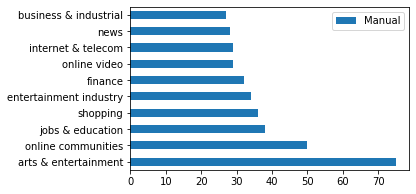

In [31]:
category_mismatch_absolute_plot(combined_mismatch, (5,3), 10)

### Which are mismatches ONLY?

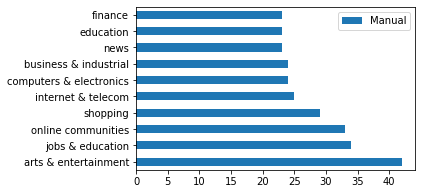

In [32]:
category_mismatch_absolute_plot(combined_mismatch_non_empty, (5,3), 10)

### Which are empty?

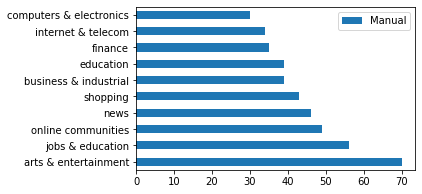

In [33]:
category_mismatch_absolute_plot(combined_empty, (5,3), 10)

#### But arts & entertainment is the most prominent label anyway. Look at the percentage of total labels

In [37]:
def category_mismatch_perc_plot(df, full_count_df, figsize, count):
    '''
    Given a filtered and unfiltered dataframe with labels, plot a bar plot of the percentage of that label that was mismatched
    Filter out the ones that have less than 10 occurrances 
    '''
    all_labels = full_count_df["Manual"].explode().value_counts()
    all_labels = all_labels[all_labels>10]
    mismatch_labels = df["Manual"].explode().value_counts()
    
    to_plot = pd.DataFrame(mismatch_labels/all_labels * 100).sort_values("Manual",ascending=False)
    to_plot.head(count).plot(kind="barh",figsize=figsize)

### Which are mismatches OR empty?

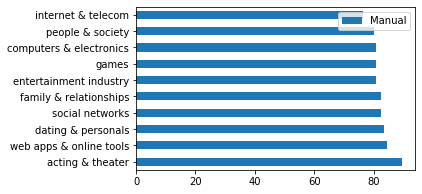

In [38]:
category_mismatch_perc_plot(combined_mismatch, combined_df, (5,3), 10)

### Which are mismatches ONLY?

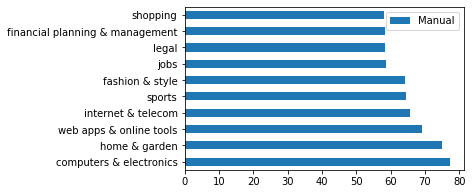

In [39]:
category_mismatch_perc_plot(combined_mismatch_non_empty, combined_df,(5,3), 10)

### Which are empty?

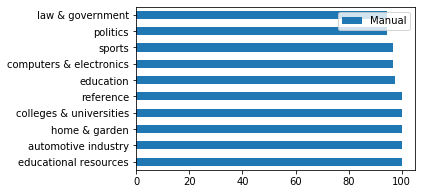

In [40]:
category_mismatch_perc_plot(combined_empty, combined_df,(5,3), 10)

## Other approaches

### CITM

In [42]:
combined_citm_df = citm_df
combined_citm_df.rename({"Labels":"CITM"},axis=1,inplace=True)
combined_citm_df["Manual"] = manual_df["Labels"]
combined_citm_df
combined_citm_df[["Match", "Empty"]] = combined_citm_df.apply(lambda x: correct_label(x["CITM"], x["Manual"]), axis=1,result_type='expand')
combined_citm_df

,CITM,Manual,Match,Empty
Website URL,,,,
suite.sogiscuola.com,"[computers & electronics, software, web browse...","[web apps & online tools, internet & telecom, ...",False,False
loadedfiles.com,"[computers & electronics, outdoors, networking...","[distributed & cloud computing, computers & el...",False,False
skemaraja.dephub.go.id,"[beauty & fitness, people & society, advertisi...","[travel & transportation, hotels & accommodati...",False,False
easy-firmware.com,"[computers & electronics, software, credit car...","[computers & electronics, software, internet &...",False,False
thesimplehelp.com,"[pets & animals, sports, gardening, wrestling,...","[career resources & planning, jobs, online com...",False,False
...,...,...,...,...
www.dish.com,"[shopping, pets, women's clothing, pets & anim...","[arts & entertainment, tv shows & programs, li...",False,False
www.adecco.fr,"[computers & electronics, consumer electronics...","[web apps & online tools, career resources & p...",False,False
www.tgcom24.mediaset.it,"[travel & transportation, music & audio, vehic...","[sports, politics, news, arts & entertainment,...",False,False


In [43]:
print("Percentage match")
temp = combined_citm_df["Match"].value_counts()
(temp[True])/(temp[True]+temp[False]) * 100

Percentage match


1.282051282051282